In [2]:
import pandas as pd
import numpy as np
import os.path as op

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}    

In [6]:
#Construct 20d CNN 
import torch
import torch.nn as nn

class CNN_20D(nn.Module):
    '''
    The input Image size is batchsize*1*64*60
    '''
    def __init__(self):
        super(CNN_20D, self).__init__()
        self.cnn_block1 = CNN_Block(in_channels=1, out_channels=64, kernel_size=[5, 3], stride=[3,1], padding=[7,1]
                                    , pooling_size=[2, 1], dilation=[2,1], negative_slope=0.01)
        self.cnn_block2 = CNN_Block(in_channels=64, out_channels=128, kernel_size=[5, 3]
                                    , pooling_size=[2, 1], negative_slope=0.01)
        self.cnn_block3 = CNN_Block(in_channels=128, out_channels=256, kernel_size=[5, 3]
                                    , pooling_size=[2, 1], negative_slope=0.01)
        self.linear = nn.Linear(
            in_features=46080, out_features=2)

    def forward(self, x):
        x = self.cnn_block1(x)
        x = self.cnn_block2(x)
        x = self.cnn_block3(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        # x = F.softmax(x)
        return x

    
    
class CNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=[5, 3],stride=1,padding=[2,1],pooling_size=[2,1],dilation=1,negative_slope=0.01):
        super(CNN_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding,dilation=dilation)
        self.max_pooling = nn.MaxPool2d(kernel_size=pooling_size)
        self.LReLU = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        x = self.conv(x)
        x = self.LReLU(x)
        x = self.max_pooling(x)
        return x

In [201]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = CNN_20D().to(device)
summary(model,(1,64,60))

Layer (type:depth-idx)                   Output Shape              Param #
├─CNN_Block: 1-1                         [-1, 64, 12, 60]          --
|    └─Conv2d: 2-1                       [-1, 64, 24, 60]          1,024
|    └─LeakyReLU: 2-2                    [-1, 64, 24, 60]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 12, 60]          --
├─CNN_Block: 1-2                         [-1, 128, 6, 60]          --
|    └─Conv2d: 2-4                       [-1, 128, 12, 60]         123,008
|    └─LeakyReLU: 2-5                    [-1, 128, 12, 60]         --
|    └─MaxPool2d: 2-6                    [-1, 128, 6, 60]          --
├─CNN_Block: 1-3                         [-1, 256, 3, 60]          --
|    └─Conv2d: 2-7                       [-1, 256, 6, 60]          491,776
|    └─LeakyReLU: 2-8                    [-1, 256, 6, 60]          --
|    └─MaxPool2d: 2-9                    [-1, 256, 3, 60]          --
├─Linear: 1-4                            [-1, 2]                   92,16

Layer (type:depth-idx)                   Output Shape              Param #
├─CNN_Block: 1-1                         [-1, 64, 12, 60]          --
|    └─Conv2d: 2-1                       [-1, 64, 24, 60]          1,024
|    └─LeakyReLU: 2-2                    [-1, 64, 24, 60]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 12, 60]          --
├─CNN_Block: 1-2                         [-1, 128, 6, 60]          --
|    └─Conv2d: 2-4                       [-1, 128, 12, 60]         123,008
|    └─LeakyReLU: 2-5                    [-1, 128, 12, 60]         --
|    └─MaxPool2d: 2-6                    [-1, 128, 6, 60]          --
├─CNN_Block: 1-3                         [-1, 256, 3, 60]          --
|    └─Conv2d: 2-7                       [-1, 256, 6, 60]          491,776
|    └─LeakyReLU: 2-8                    [-1, 256, 6, 60]          --
|    └─MaxPool2d: 2-9                    [-1, 256, 3, 60]          --
├─Linear: 1-4                            [-1, 2]                   92,16

In [7]:
model = torch.load('./model_last.pkl')

In [11]:
model.eval()

CNN_20D(
  (cnn_block1): CNN_Block(
    (conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(7, 1), dilation=(2, 1))
    (max_pooling): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (LReLU): LeakyReLU(negative_slope=0.01)
  )
  (cnn_block2): CNN_Block(
    (conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (max_pooling): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (LReLU): LeakyReLU(negative_slope=0.01)
  )
  (cnn_block3): CNN_Block(
    (conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (max_pooling): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (LReLU): LeakyReLU(negative_slope=0.01)
  )
  (linear): Linear(in_features=46080, out_features=2, bias=True)
)

In [82]:
# 对单个图像可视化
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image
from torchvision.models import resnet50
import cv2
import numpy as np
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#model = torch.load('model_v1.pkl')
# 2.选择目标层
target_layers = [model.cnn_block1]
# 3. 构建输入图像的Tensor形式

year = 2019
images = np.memmap(op.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, 64, 60))
im_tensor=torch.from_numpy(images)/255
im_tensor=im_tensor.reshape(len(images),1,64,60)
input_tensor = im_tensor[32455]
input_tensor = input_tensor.reshape(1,1,64,60)

rgb_img = cv2.cvtColor(images[32455], cv2.COLOR_GRAY2BGR)
rgb_img = np.float32(rgb_img) / 255

# # preprocess_image作用：归一化图像，并转成tensor
# input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406],
#                                              std=[0.229, 0.224, 0.225])   # torch.Size([1, 3, 224, 224])

# 4.初始化GradCAM，包括模型，目标层以及是否使用cuda
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# 5.选定目标类别，如果不设置，则默认为分数最高的那一类
target_category = None # 281

# 6. 计算cam
grayscale_cam = cam(input_tensor=input_tensor.cuda() , target_category=target_category)  # [batch, 224,224]

# 7.展示热力图并保存, grayscale_cam是一个batch的结果，只能选择一张进行展示
grayscale_cam = grayscale_cam[0]
visualization = show_cam_on_image(rgb_img, grayscale_cam)  # (224, 224, 3)
cv2.imwrite(f'32455-1.jpg', visualization)

True

In [71]:
# image_path = './both.png'
# rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]   # 1是读取rgb

rgb_img = cv2.cvtColor(images[0], cv2.COLOR_GRAY2BGR)
rgb_img = np.float32(rgb_img) / 255
rgb_img.shape

(64, 60, 3)

5


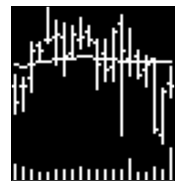

36


<Figure size 432x288 with 0 Axes>

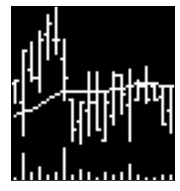

8084


<Figure size 432x288 with 0 Axes>

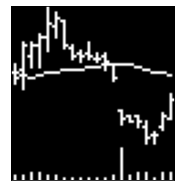

10021


<Figure size 432x288 with 0 Axes>

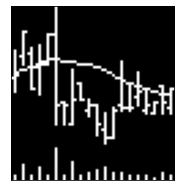

20454


<Figure size 432x288 with 0 Axes>

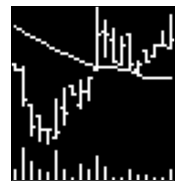

<Figure size 432x288 with 0 Axes>

In [3]:
year = 2019
images = np.memmap(op.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
from matplotlib import pyplot as plt
for i in [5,36,8084,10021,20454]:
    print(i)
    plt.figure(figsize=(3, 3.2))
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])
    plt.show()
    plt.savefig(str(i)+'-0.jpg', bbox_inches='tight')